# Input Distributions

**Goal:** We moved from the Topo to the PFlow jet collection, so as a sanity check, we just want to compare the input distributions that we're feeding to our algorithms.

It might also be fun the c.f. the # of tracks with positve and negative signage to see how much the jet axis is helping us?

As a side note, Sanmay in parallel has been looking at the input distributions for DL1, and he noticed a wierd spike in the $p_\tau$ distribution. So I'm going to c.f. the RNN outputs for
1. Topo trained model eval on topo
2. Topo trained model eval on PFlow
3. PFlow trained model eval on PFlow

I'm going to be doing this "validation study" looking at an mc16d ttbar sample.


In [1]:
import numpy as np
import h5py
import sys
import pandas as pd
import xarray as xr

sys.path.append("../..")
from usefulFcts import *
from trainNet import *
from plottingFcts import *

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


**Step 1:** Open the datafiles

Note: I need to open the scaling files for these distribuions as well!

In [2]:
vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"
dataDir = '../../data/'
dataTagTest = "2mtest_15trks_{}_sd0_rev".format(vStr)
dataTagTrain = "3mtrain_15trks_{}".format(vStr)

# Topo
f_name = "{}/mc16d_Topo_ttbar/data_{}.hdf5".format(dataDir,dataTagTest)
f = h5py.File(f_name,"r")

X_topo = f['X_test'][:]
y_topo = f['y_test'][:]

f.close()

s_name = "{}/mc16d_Topo_ttbar/scale_{}.json".format(dataDir,dataTagTrain)
with open(s_name, 'r') as sfile:
    dict_topo = json.load(sfile)


# PFlow
f_name = "{}/mc16d_PFlow_ttbar/data_{}.hdf5".format(dataDir,dataTagTest)
f = h5py.File(f_name,"r")

X_pflow = f['X_test'][:]
y_pflow = f['y_test'][:]

f.close()

s_name = "{}/mc16d_PFlow_ttbar/scale_{}.json".format(dataDir,dataTagTrain)
with open(s_name, 'r') as sfile:
    dict_pflow = json.load(sfile)

In [3]:
jetCollections = ['Topo', 'PFlow']
trk_vars = strToList(vStr,'_')

In [4]:
trk_vars

['sd0',
 'sz0',
 'nNextToInnHits',
 'nInnHits',
 'nsharedBLHits',
 'nsplitBLHits',
 'nsharedPixHits',
 'nsplitPixHits',
 'nsharedSCTHits',
 'logNorm',
 'ptfrac',
 'dr',
 'norm',
 'nPixHits',
 'nSCTHits']

In [5]:
trk_vars.remove('logNorm')
trk_vars.remove('norm')
trk_vars

['sd0',
 'sz0',
 'nNextToInnHits',
 'nInnHits',
 'nsharedBLHits',
 'nsplitBLHits',
 'nsharedPixHits',
 'nsplitPixHits',
 'nsharedSCTHits',
 'ptfrac',
 'dr',
 'nPixHits',
 'nSCTHits']

In [6]:
logNormVars = trk_vars[-4:-2]
normVars = trk_vars[-4:]

In [7]:
logNormVars

['ptfrac', 'dr']

In [8]:
normVars

['ptfrac', 'dr', 'nPixHits', 'nSCTHits']

In [9]:
xlabels = ['$s_{d0}$', '$s_{z0}$', 
           'PIX1 hits', 'IBL hits',
           'IBL shared hits', 'IBL split hits', 
           'shared pixel hits', 'split pixel hits',
           'shared SCT hits','$p_T^{frac}$','$\Delta R$',
           'pixel hits','SCT hits'
          ]

var_bins = [50,50,
            5,5,5,5,
            10,10,10,
            50,50,
            10,21]

var_ranges = [(-10,10),(-10,10),
              (-0.5,4.5),(-0.5,4.5),(-0.5,4.5),(-0.5,4.5),
              (-0.5,9.5),(-0.5,9.5),(-0.5,9.5),
              (0,0.4), (0, .4),
              (-0.5,9.5),(-0.5,20.5)]

In [10]:
dict_topo

{'ptfrac': {'mean': -2.7100813388824463, 'sd': 0.9212613701820374},
 'dr': {'mean': -2.3626036643981934, 'sd': 0.9019189476966858},
 'nPixHits': {'mean': 4.153148174285889, 'sd': 0.8018356561660767},
 'nSCTHits': {'mean': 8.082289695739746, 'sd': 1.494708776473999}}

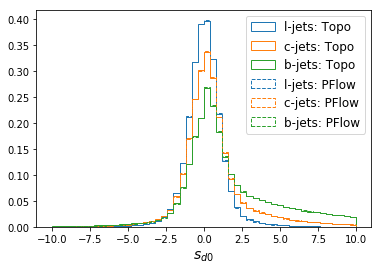

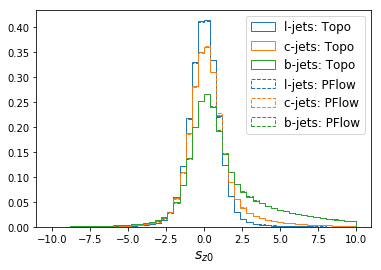

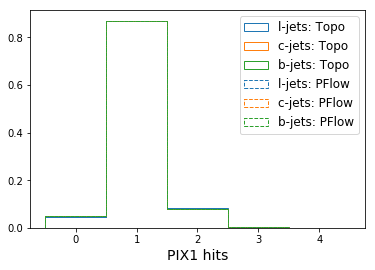

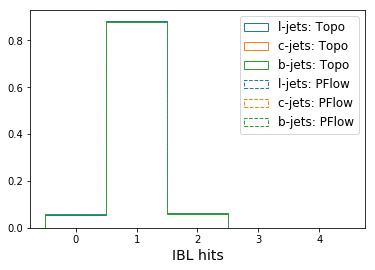

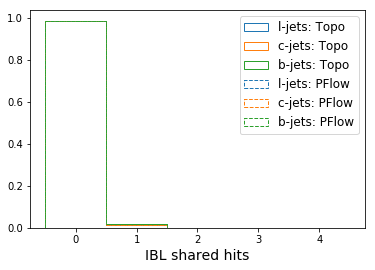

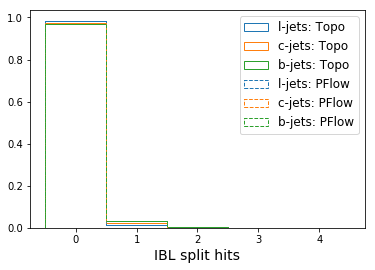

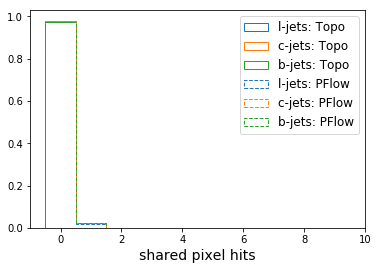

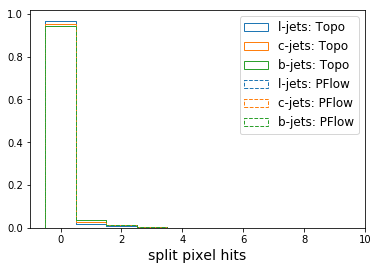

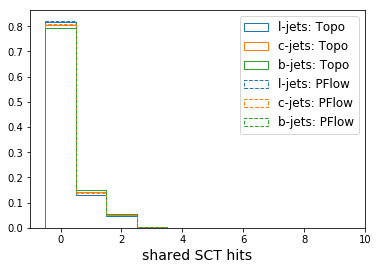

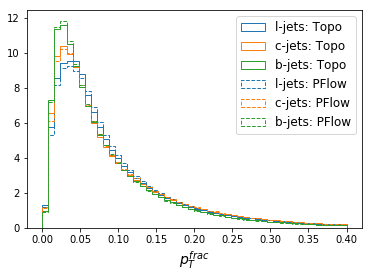

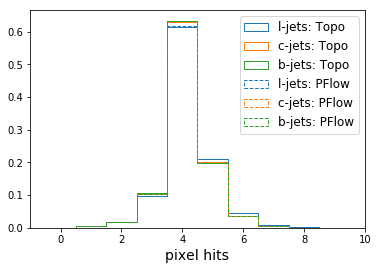

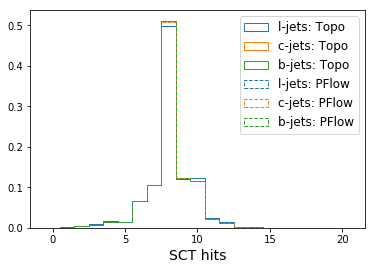

In [11]:
for i,(X, y, d, jetCollection, l) in enumerate(zip([X_topo,X_pflow], [y_topo,y_pflow], 
                                                   [dict_topo, dict_pflow], jetCollections, ['-','--'])):

    # Get the mask since all of the truth labels are track level variables
    y_trks = np.ones_like(X[:,:,0])
    y_trks = y_trks * y.reshape(-1,1)

    # This mask selects the non-masked tracks in the jet
    mask = getTrkMask(X)
    y_trks = y_trks[mask]

    for j, (trk_var, xlabel, nBins, myRange) in enumerate(zip(trk_vars, xlabels,var_bins, var_ranges)):

        # Access the non-masked trks in the jet for this trk feature
        var = X[:,:,j][mask].copy()
        
        if trk_var in normVars:
            mu, sigma = d[trk_var]['mean'], d[trk_var]['sd']
            var = mu + sigma * var
        
        if trk_var in logNormVars:
            var = np.exp(var)
            
        plt.figure(j)

        for yi, flav in zip(range(3), ['l','c','b']):

            plt.hist(var[y_trks == yi],
                     range=myRange,bins=nBins,
                     histtype='step', density=True, 
                     color='C{}'.format(yi), linestyle=l,
                     label='{}-jets: {}'.format(flav,jetCollection))

        plt.legend(fontsize=12)  
        plt.xlabel(xlabel,fontsize=14)            
        plt.savefig('../../figures/mc16d_PFlow_ttbar/Topo_cf/{}.pdf'.format(trk_var))

plt.show()

### Checking Sanmay's $p_\tau$ claim

Ok, so in the [Jan 17th algs meeting](https://indico.cern.ch/event/783073/contributions/3280991/attachments/1780564/2896554/FlavorTagging_19_01_17.pdf), Sanmay said that the $p_\tau$ distributions had a spike for PFlow jets.

<img src="../../figures/mc16d_PFlow_ttbar/ptau.png" width="400">

The goal is to see if I see this effect as well , so I'm going to do this test w/ mc16d ttbar.

**Plan:**
- Load in the models you trained on mc16d Topo and PFlow
- Evaluate the Topo trained model on Topo and PFlow
- Evaluate the PFlow model on PFlow

Extra: I could see if applying the *wrong* JVT cut generates this $p_\tau$ peak!

In [12]:
# models
modelDir = '../../models/'
nFeatures = X_topo.shape[-1]

# topo
subDir = 'mc16d_Topo_ttbar'
m_topo = myLSTM(modelDir=modelDir+subDir, nFeatures=nFeatures, dataTag=dataTagTrain, loadModel=True)

    
# pflow
subDir = 'mc16d_PFlow_ttbar'
m_pflow = myLSTM(modelDir=modelDir+subDir, nFeatures=nFeatures, dataTag=dataTagTrain, loadModel=True)


Initialize method from myModel()
Building the baseline LSTM
Initialize method from myModel()
Building the baseline LSTM


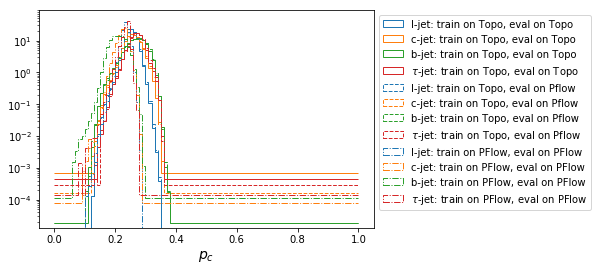

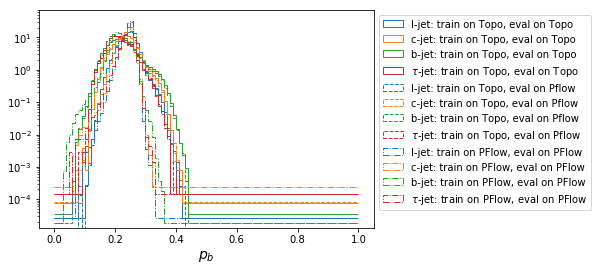

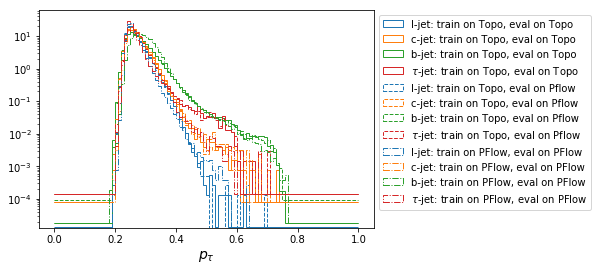

In [20]:
#Get the output nodes
figDir = '../../figures/'
labels = ['train on Topo, eval on Topo',
          'train on Topo, eval on Pflow',
          'train on PFlow, eval on PFlow']
  
predictions = []
    
for m, X, y, label,l in zip([m_topo,m_topo,m_pflow],[X_topo,X_pflow,X_pflow],
                            [y_topo,y_pflow,y_pflow],labels,['-','--','-.']):

    # Evaluate the model
    preds = m.eval(X)
    predictions.append(preds)
    
    # Plot the distributions for each output node
    for i,xlabel in enumerate(['$p_l$','$p_c$','$p_b$',r'$p_\tau$']):
        
        for yi,jet in enumerate(['l','c','b',r'$\tau$']):
            
            plt.figure(i)
            plt.hist(preds[:,i][y==yi],bins=100,range=(0,1),
                     histtype='step',linestyle=l,color='C{}'.format(yi),
                     label=jet+'-jet: '+label,density=True,log=True)

for i,(xlabel,node) in enumerate(zip(['$p_l$','$p_c$','$p_b$',r'$p_\tau$'],['l','c','b','tau'])):
    plt.figure(i)
    plt.legend(bbox_to_anchor=(1,1))
    plt.xlabel(xlabel,fontsize=14)
    plt.savefig('{}/mc16d_PFlow_ttbar/Topo_cf/p{}.pdf'.format(figDir,node),bbox_inches='tight')
    
plt.show()

**Thoughts:**
- Ok, something else that I don't understand is why Sanmay has $p_\tau$ values going out to 10, I thought the RNNIP outputs were supposed to just go between (0,1), by definition, since the probabilities need to sum to 1?